# Autoencoders in PyTorch

In this notebook, we'll build an autoencoder with PyTorch. I like autoencoders because they are a straightforward but interesting model to implement. It's a good first project when learning a new framework.

Just as a reminder, autoencoders attempt to find a compressed representation for some dataset. The model does this by encoding the data into a smaller number of values, a compressed vector. During training, the vector is passed through a decoder which attempts to reconstruct the original data. The loss is then the mean squared error between the reconstruction and the original data.

<img src="assets/autoencoder_1.png">

Here, we'll use PyTorch to build the encoder and decoder, then train up the network. You can read more about autoencoders and implementing them in TensorFlow [here]( https://github.com/udacity/deep-learning/tree/master/autoencoder).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms

from helper import test_network, view_recon

In [ ]:
# Get the data
transform = transforms.Compose([
                              transforms.ToTensor(),
                              # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             ])
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

## Building the network

Here we'll build the network for the autoencoder.

Again, we start it by creating a class inheriting from `nn.Module`. The way I did this was splitting the forward pass into two methods, `encoder` and `decoder`. This is because after training, we will usually just want the encoded vector. In the `forward` method, we just connect the two.

```python
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define the layers and operations here
        
    def forward(self, x):
        
        x = self.encoder(x)
        logits = self.decoder(x)
        
        return logits

    def encoder(self, x):
        # Forward pass through the encoder
        return x
    
    def decoder(self, x):
        # Forward pass through the decoder
        return x
```
        
### The Encoder

For the encoder, we'll use convolutional layers with `nn.Conv2d`. You can use max-pooling for downsampling, with ``nn.MaxPool2d``, but I chose to leave it out since many people seem to be moving away from pooling and downsampling with strides instead. I also added dropout with the [`nn.Dropout2d`](http://pytorch.org/docs/nn.html#dropout2d) module. With the dropout module, you'll want to turn off dropout while you're infering, you can do that with `net.eval()`. To turn dropout back on, use `net.train()`. This also works for things like batch normalization.

So, in the encoder forward pass, it would look something like

```python
x = self.drop(F.relu(self.conv1(x)))
```

with the convolutional layer, a ReLU activation, and dropout.

Typically you'll start with the first convolutional layer as the deepest layer, then use shallower layers as you compress the representation. For instance, you could use three max-pool-convolution layers with depths 16, 8, and 8. If you downsample by two with each layer (use strides of two and "same" padding), you'll end up with a layer that is 8x4x4. Feel free to choose whatever depths you want, and however many layers you as well.

### The decoder

With the decoder, you'll need to upsample the layers. This can be done with transposed convolutions ([nn.ConvTranspose2d](http://pytorch.org/docs/nn.html#convtranspose2d)) or by nearest neighbor upsampling ([nn.UpsamplingNearest2d](http://pytorch.org/docs/nn.html#upsamplingnearest2d)). With transposed convolutions, you define the kernel size and strides like normal, but when you call the module, you can set an output size. That is, you'd define the operation as
```python
self.upconv = nn.ConvTranspose2d(8, 8, 3, stride=2, padding=1)
```

then in the forward pass

```python
x = self.upconv(x, output_size=(14,14))
```

Similarly with nearest neighbor, you set the size of the output `self.upsample = nn.UpsamplingNearest2d(size=(14, 14))`.

If you're using transposed convolutions, the forward pass would look like `x = self.drop(F.relu(self.upconv1(x, output_size=(7,7))))` to upsample to 7x7 layer, with a ReLU activation and dropout. Typically you'd upsample through a few layers, something like depths of 8, 8, and 16. Then the output layer would be another convolutional layer with a depth of 1 to match the MNIST images. If you were working with color images like CIFAR or SVHN, you'd use a depth of 3.

Which upsampling method you choose depends on a lot of factors. Distill [recently published](http://distill.pub/2016/deconv-checkerboard/) a good article about the differences. They show that transposed convolutional layers can sometimes result in checkerboard artifacts and nearest neighbor upsampling works better. But, I've found that transposed convolutions work great for this model. So, try out both methods if you're curious.

If you need a refresher on building autoencoders with convolutions and upsampling, check out [this notebook](https://github.com/udacity/deep-learning/blob/master/autoencoder/Convolutional_Autoencoder_Solution.ipynb). And here [we used transposed convolutions](https://github.com/udacity/deep-learning/blob/master/dcgan-svhn/DCGAN.ipynb) to build the generator of a GAN.

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc_fc1 = nn.Linear(784, 50)
        self.enc_fc2 = nn.Linear(50, 10)

        # Decoder
        self.dec_fc1 = nn.Linear(10, 40)
        self.dec_fc2 = nn.Linear(40, 784)

        # activation
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        # x:
        # print("x shape:", x.shape)
        z = self.encode(x.reshape(-1, 784))
        # print("z shape:", z.shape)
        recon = self.decode(z).reshape(-1, 28, 28)
        # print("recon: ", recon.shape)
        return recon, z

    def encode(self, x):
        x = self.activation(self.enc_fc1(x))
        return self.enc_fc2(x)

    def decode(self, x):
        x = self.activation(self.dec_fc1(x))
        return self.dec_fc2(x)

## Training the network

Now we'll train the network. We're using the mean square error for the loss, so we'll use `criterion = nn.MSELoss()`. As before, we update the weights by doing a forward pass through the network, then calculate the loss, get the gradients with `loss.backward()`, then make an update step with `optimizer.step()` (with an Adam optimizer, `optim.Adam`).

In [ ]:
net = Network()

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epochs = 1
print_every = 200  # Number of training steps to print losses
show_every = 1000  # Number of training steps to show reconstructions
cuda = True        # Train on GPU or not

if cuda:
    net.cuda()

steps = 0
running_loss = 0
for e in range(epochs):
    start = time.time()
    for images, labels in trainloader:
        steps += 1

        inputs = Variable(images)
        targets = Variable(images)

        if cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()

        output, z = net(inputs)
        loss = criterion(output, targets.squeeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            net.eval()
            stop = time.time()
            # Test accuracy
            val_loss = 0
            for ii, (images, labels) in enumerate(testloader):

                #images = images.resize_(images.size()[0], 784)
                inputs = Variable(images, volatile=True)
                targets = Variable(images, volatile=True)
                if cuda:
                    inputs, targets = inputs.cuda(), targets.cuda()

                output, _ = net.forward(inputs)
                val_loss += criterion(output, targets.squeeze(1)).item()

            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(running_loss/print_every),
                  "Test loss: {:.4f}..".format(val_loss/(ii+1)),
                  "{:.4f} s/batch".format((stop - start)/print_every)
                 )

            running_loss = 0
            start = time.time()
            net.train()

        if steps % show_every == 0:
            net.cpu()
            net.eval()
            img = images[3]
            x = Variable(img.resize_(1, *img.size()), volatile=True)
            recon = net(x).detach().squeeze()

            f, axarr = plt.subplots(1,2)
            axarr[0].imshow(img.squeeze())
            axarr[1].imshow(recon)

            plt.show()
            if cuda:
                net.cuda()
            net.train()

<ipython-input-17-01f6f949cd00>:43: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs = Variable(images, volatile=True)
<ipython-input-17-01f6f949cd00>:44: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  targets = Variable(images, volatile=True)


Epoch: 1/1.. Loss: 0.0643.. Test loss: 0.0448.. 0.0086 s/batch
Epoch: 1/1.. Loss: 0.0400.. Test loss: 0.0366.. 0.0097 s/batch
Epoch: 1/1.. Loss: 0.0354.. Test loss: 0.0339.. 0.0081 s/batch
Epoch: 1/1.. Loss: 0.0337.. Test loss: 0.0330.. 0.0080 s/batch


## Encoding images

Now that the network is trained, let's encode an image and check out the vector representation.

In [ ]:
net.cpu()
dataiter = iter(trainloader)
images, labels = next(dataiter)

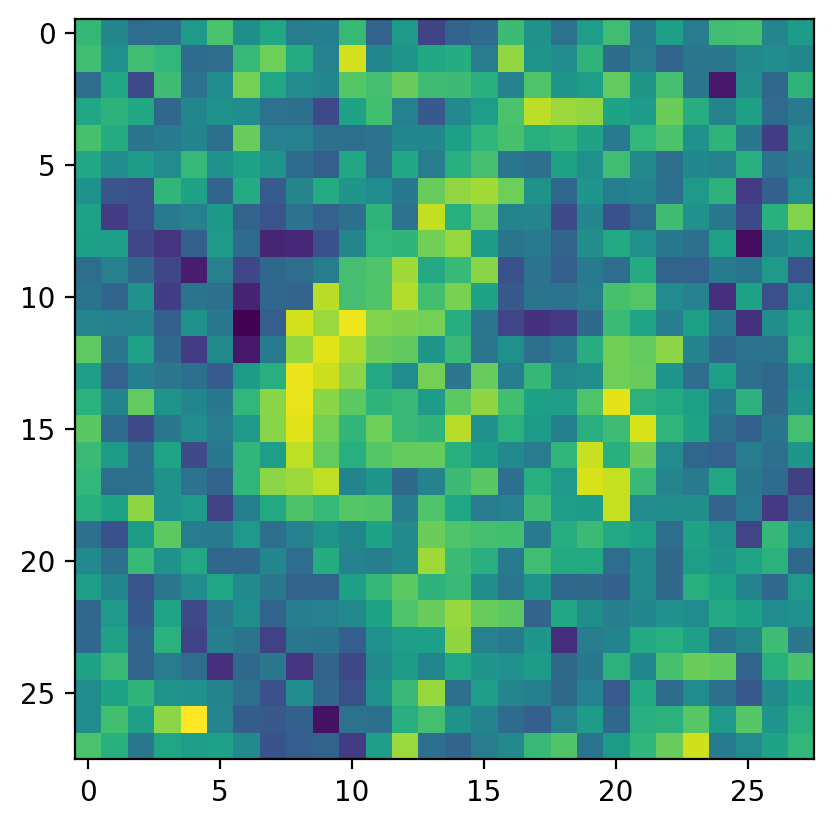

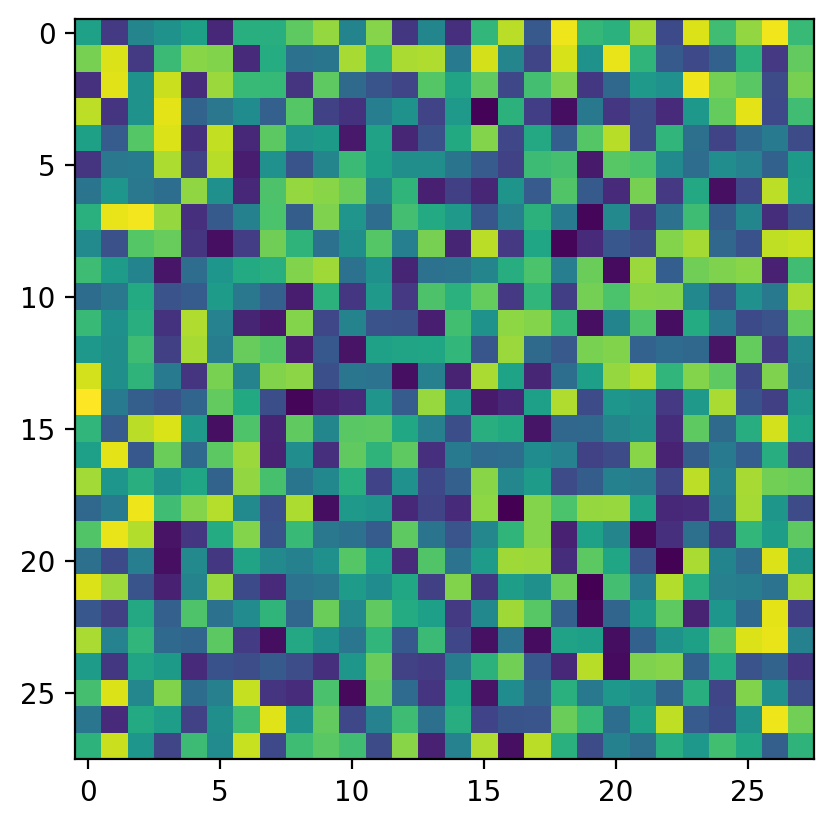

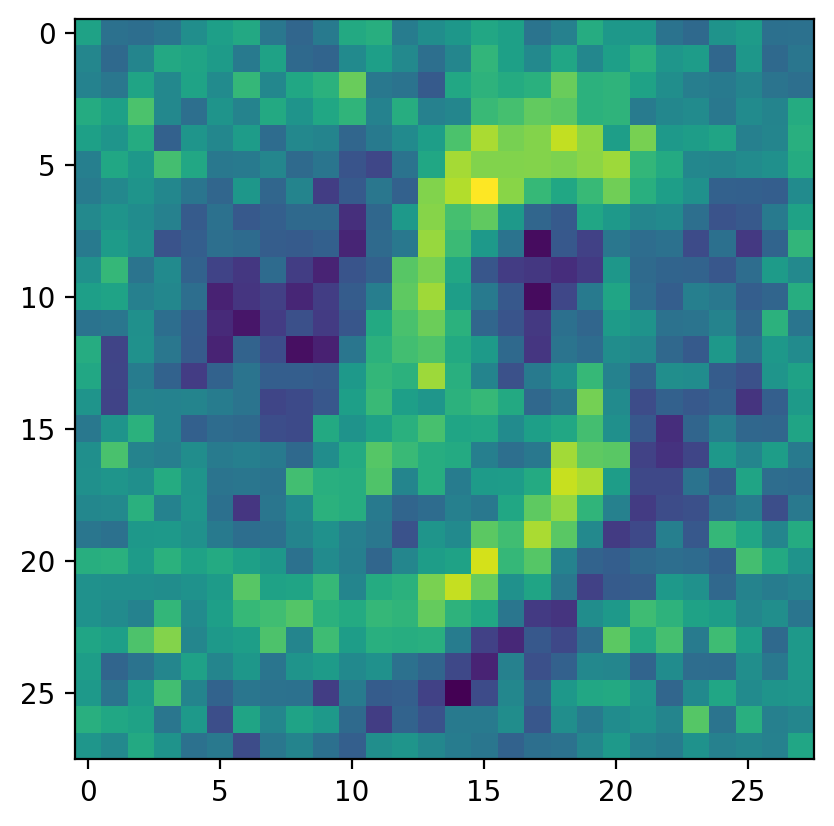

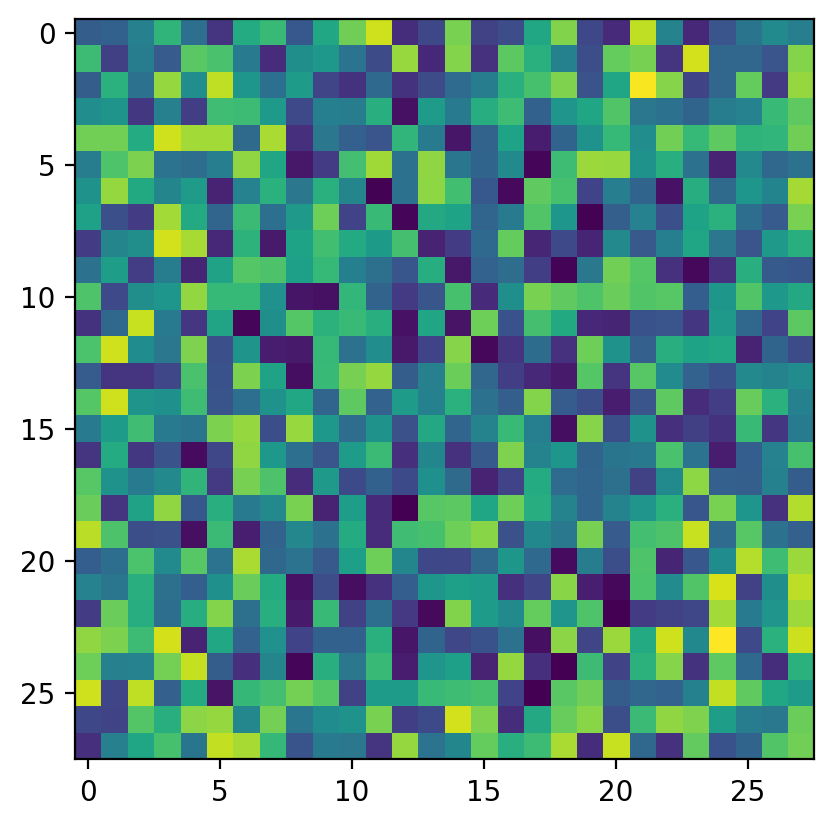

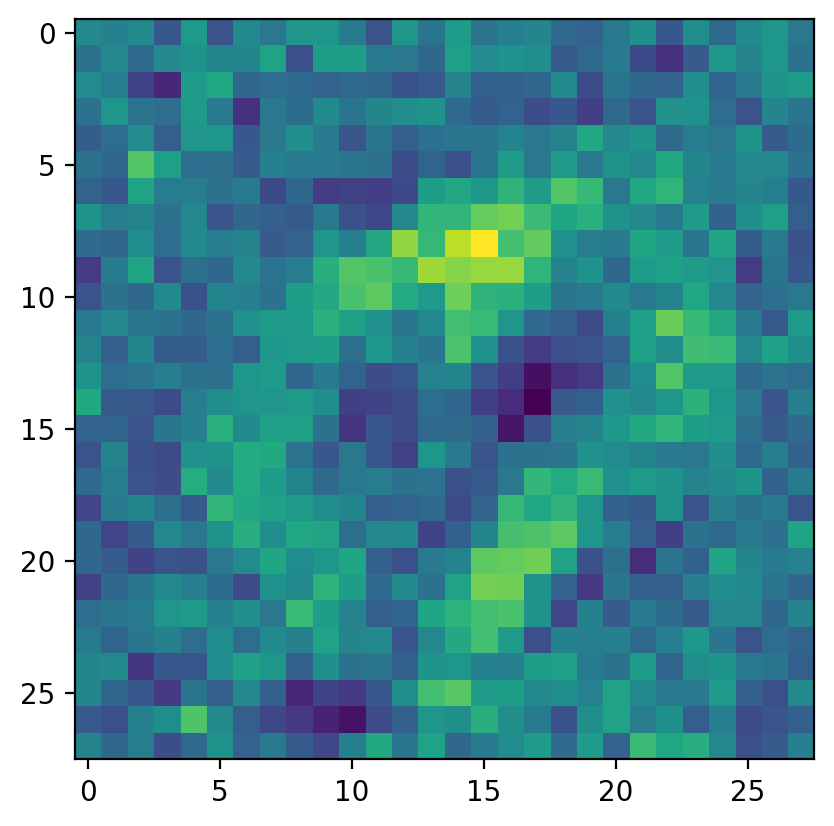

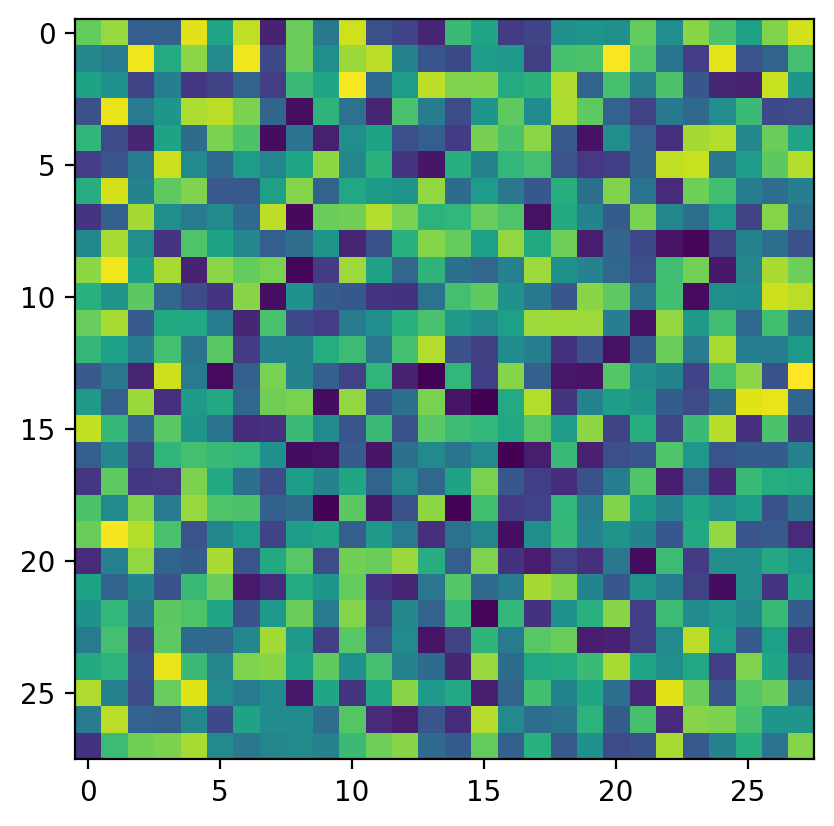

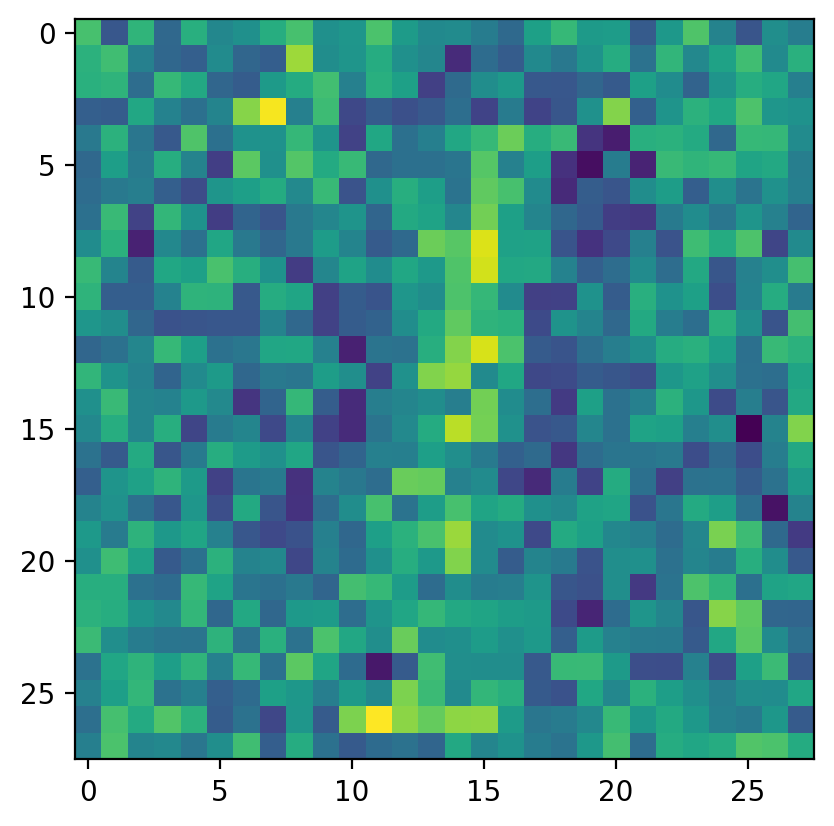

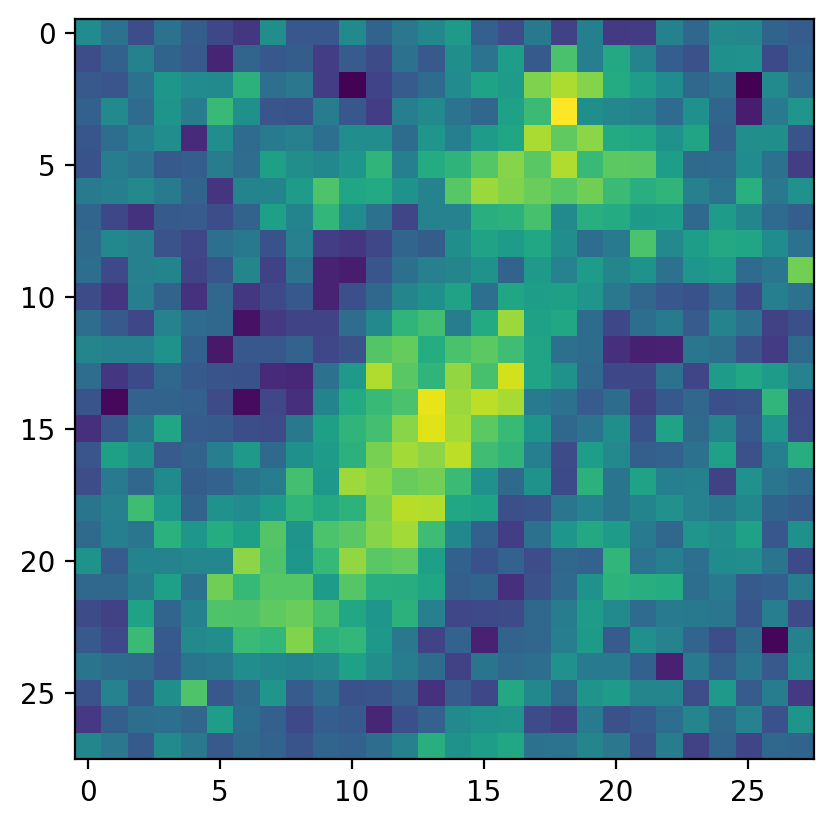

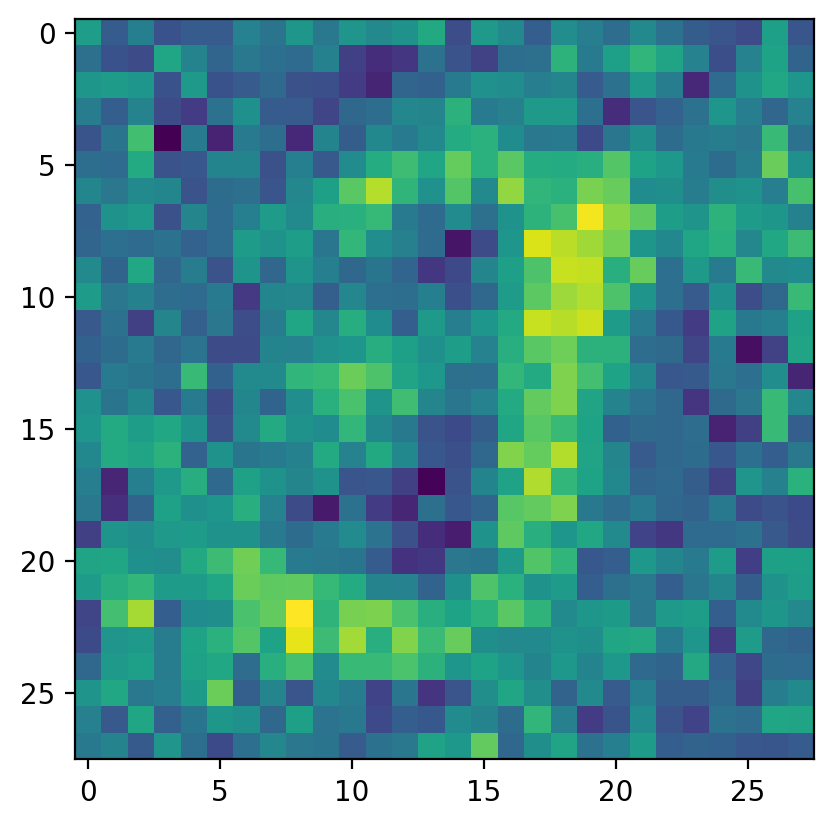

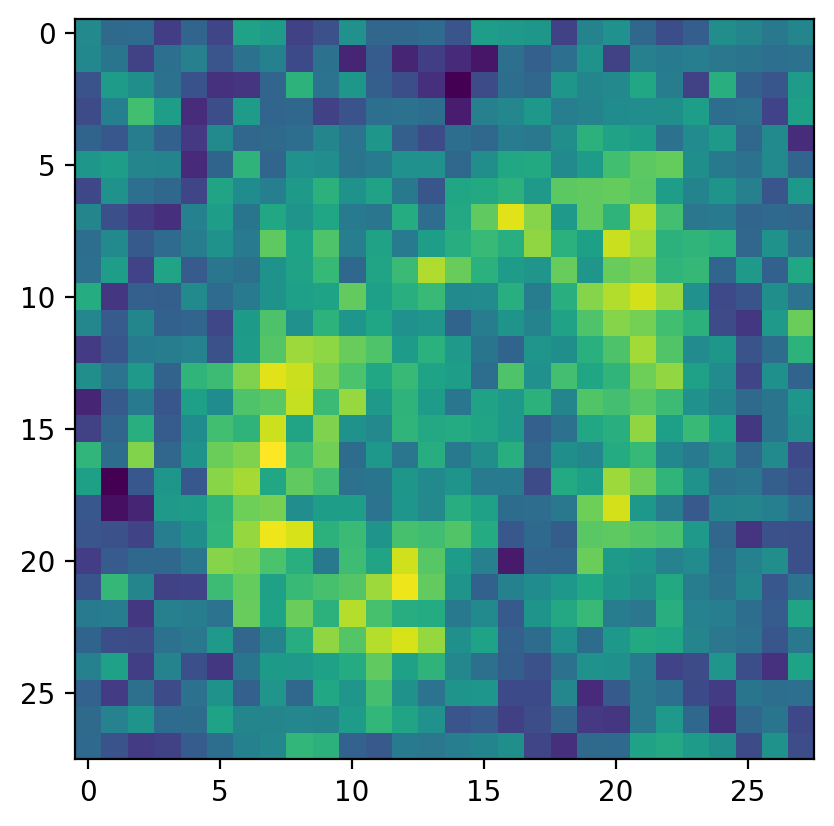

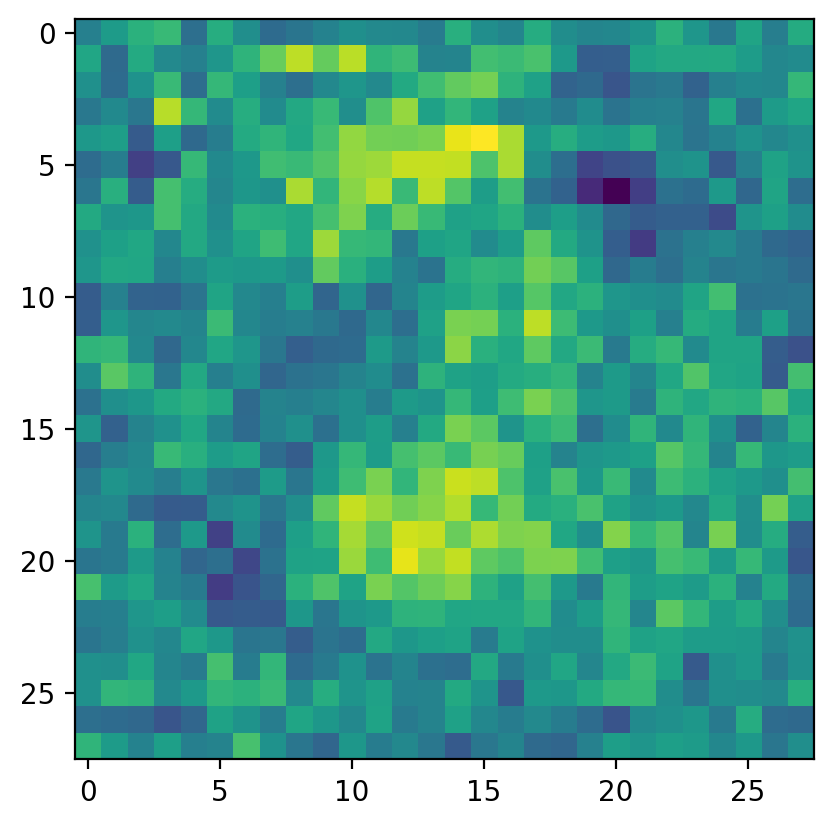

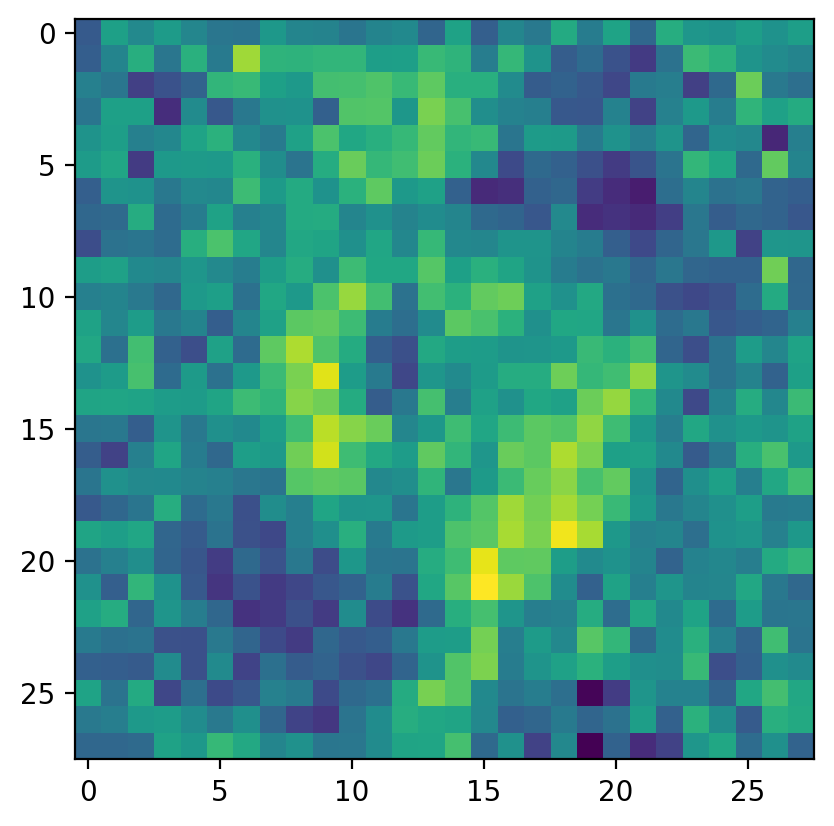

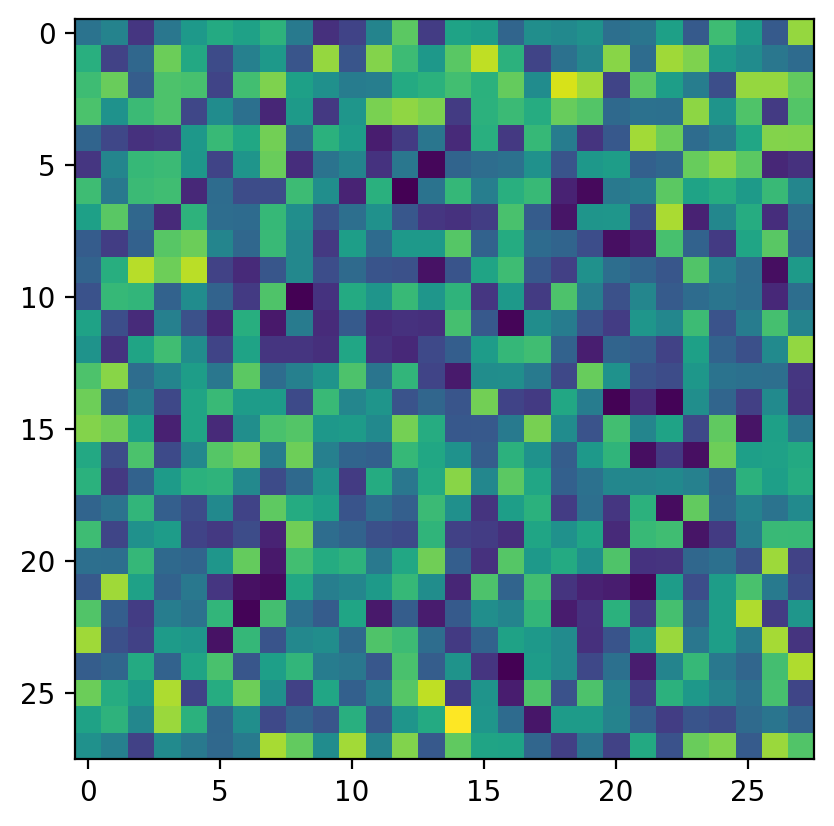

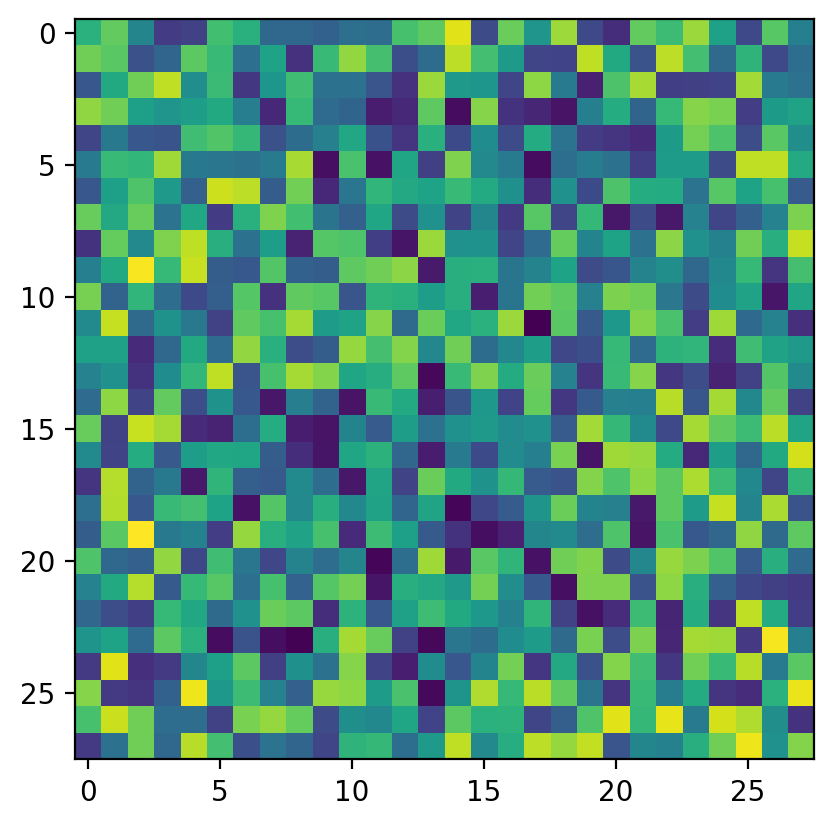

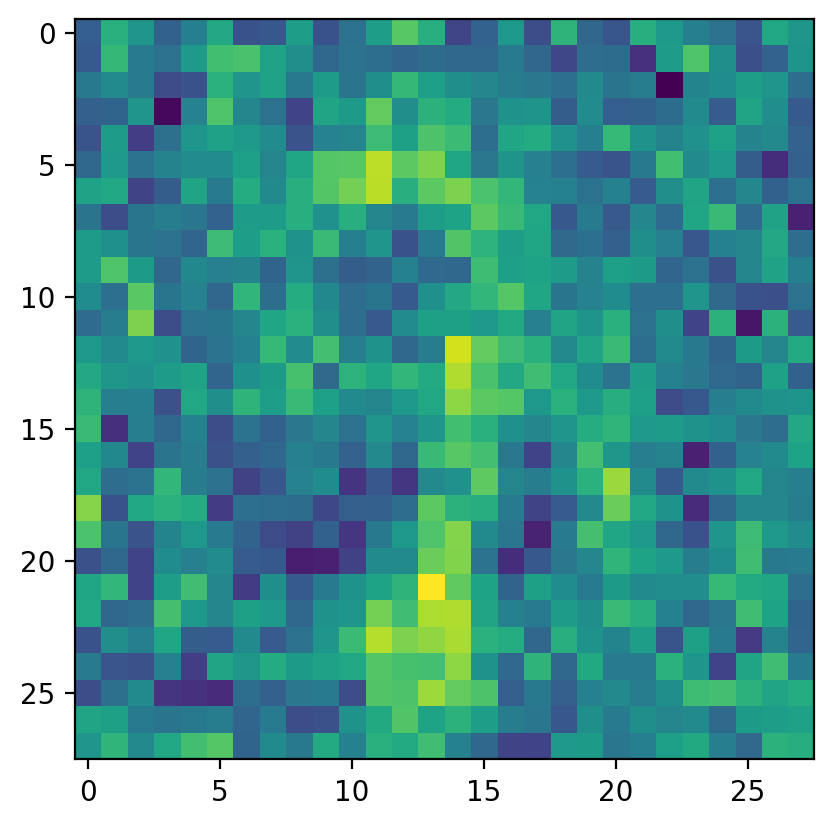

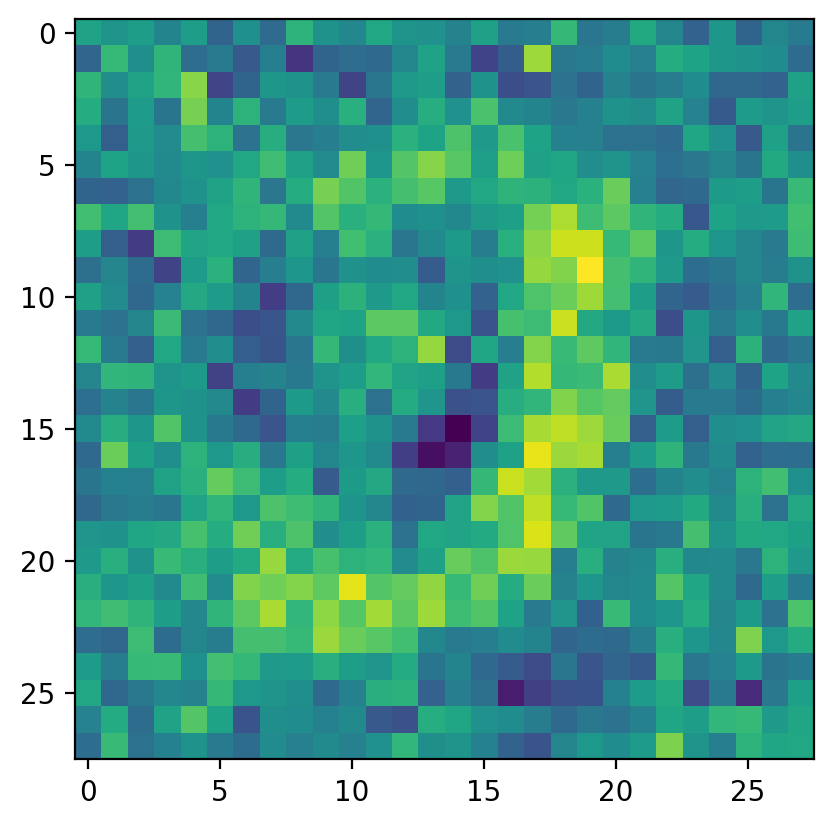

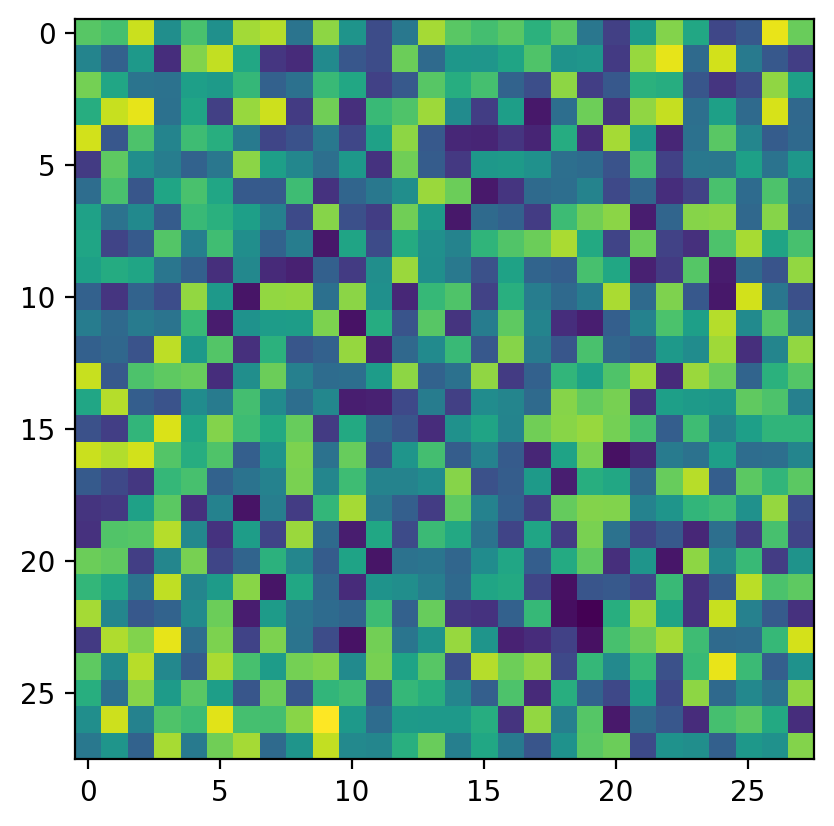

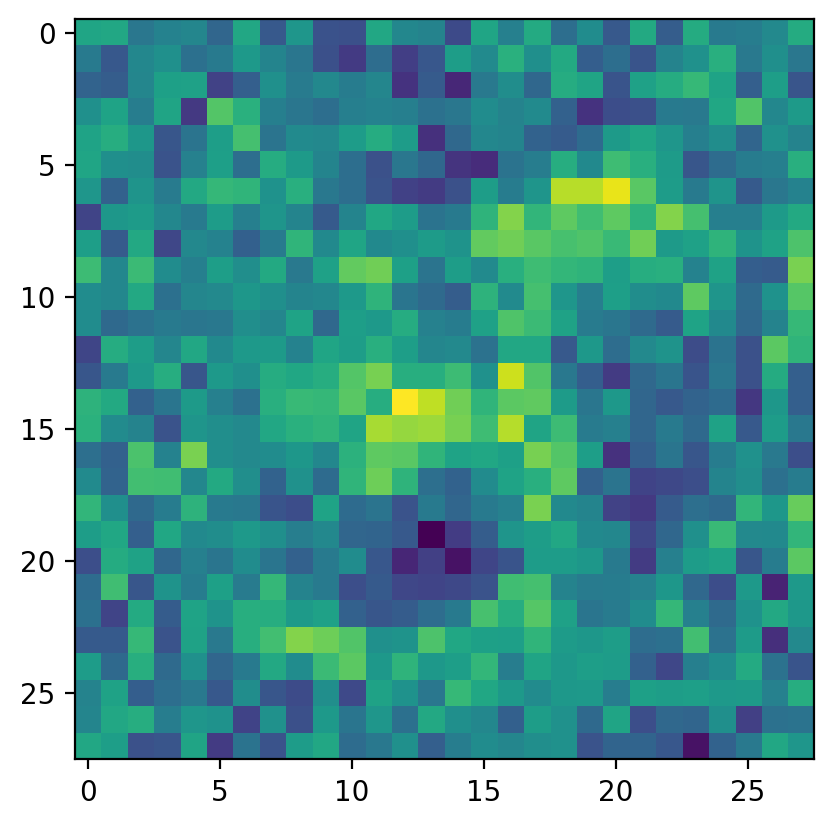

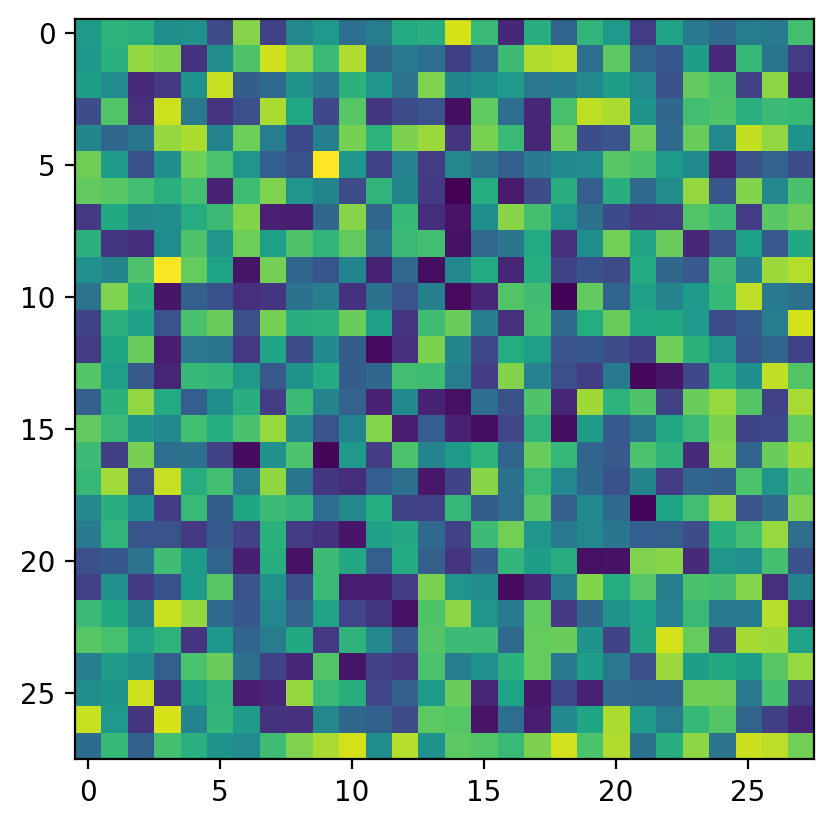

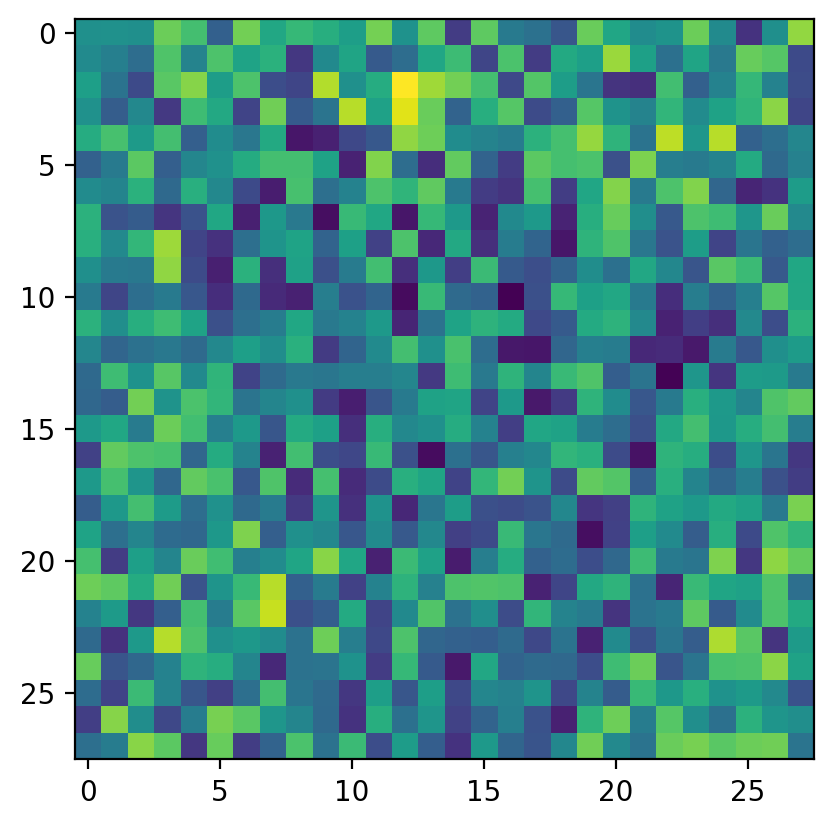

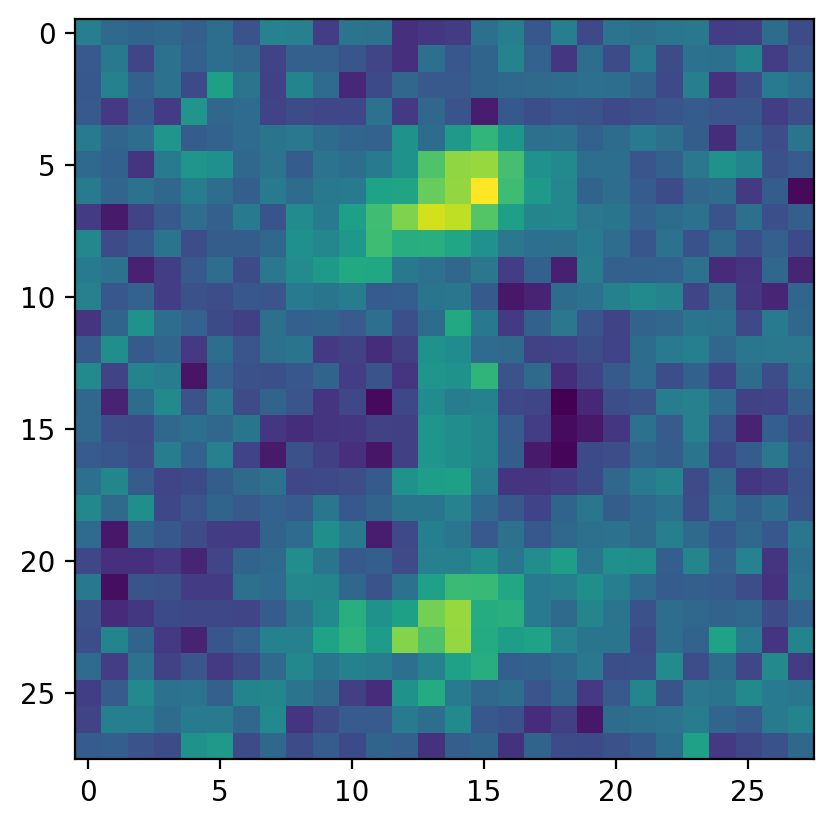

KeyboardInterrupt: 

In [ ]:
from time import sleep
all_w = net.enc_fc1.weight.detach().numpy()

for w in all_w[:10]:
    plt.imshow(w.reshape(28, 28))
    plt.show()
    sleep(.2)

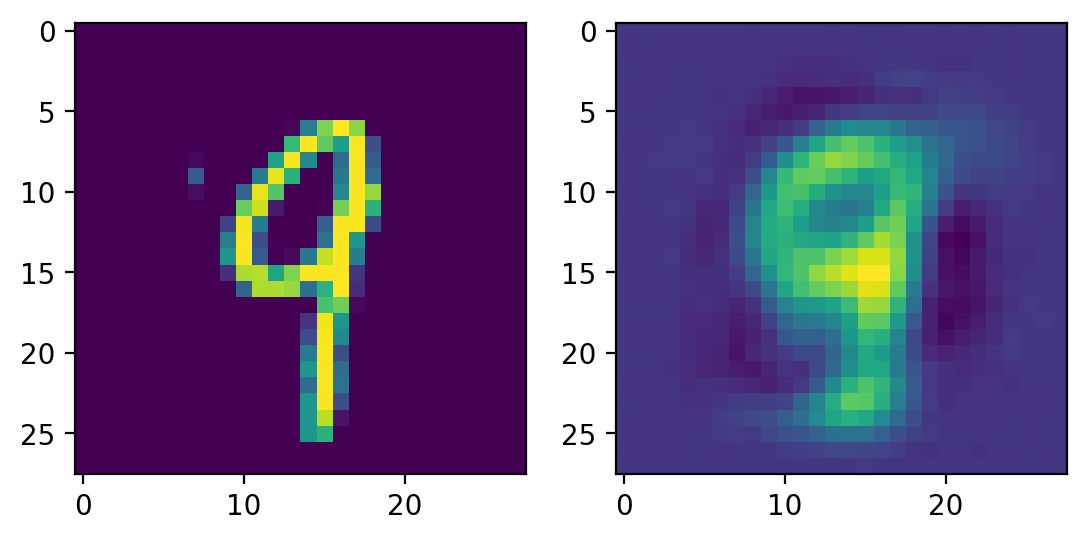

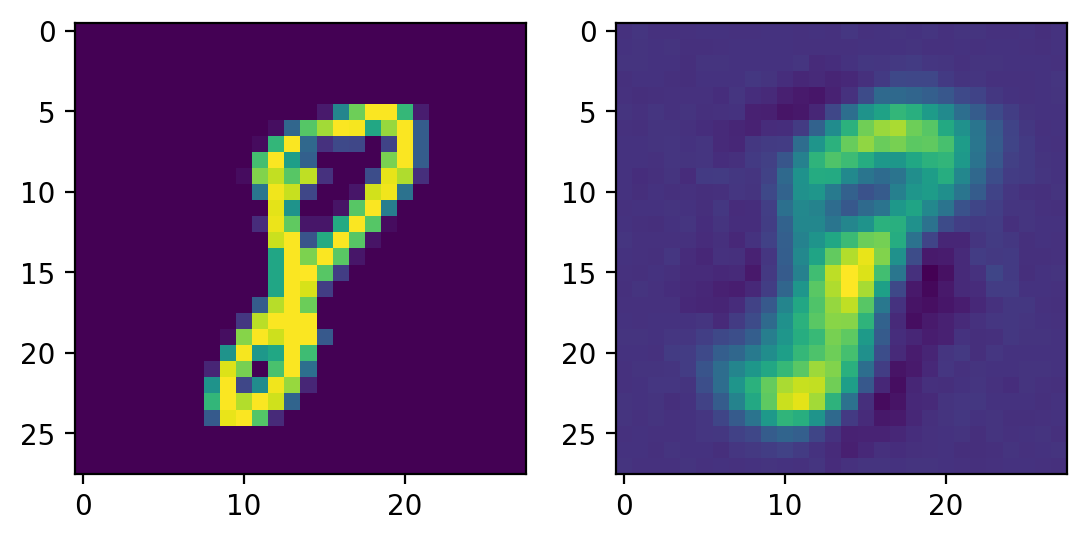

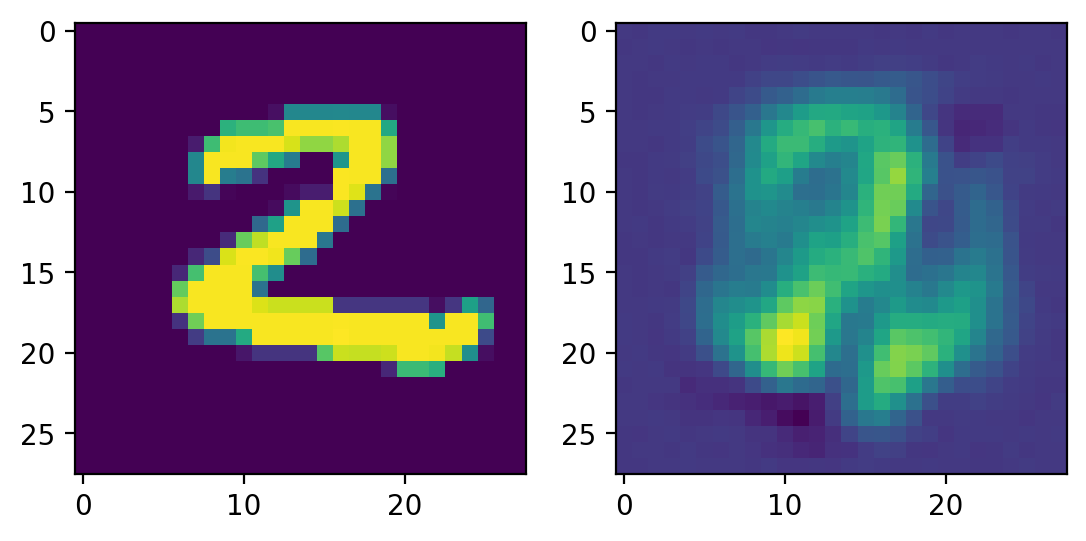

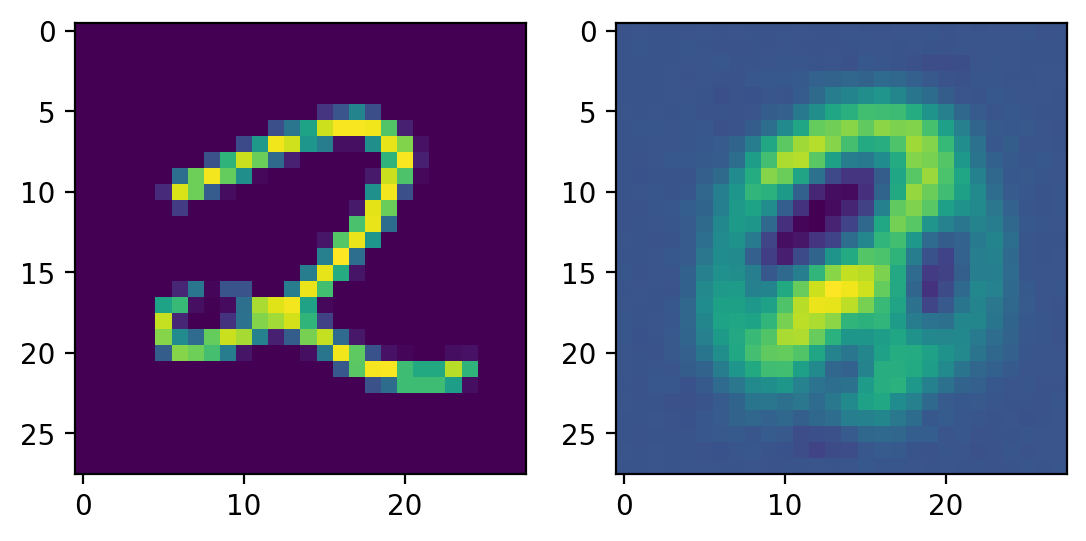

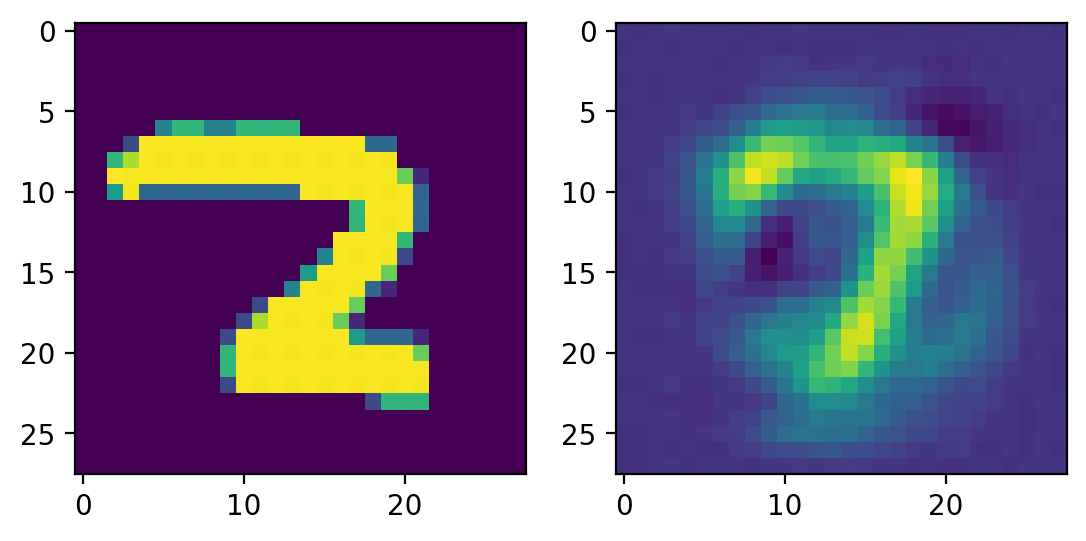

In [ ]:
for img in images[:5]:
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(img.squeeze())

    axarr[1].imshow(net(img)[0].detach().squeeze())

    plt.show()

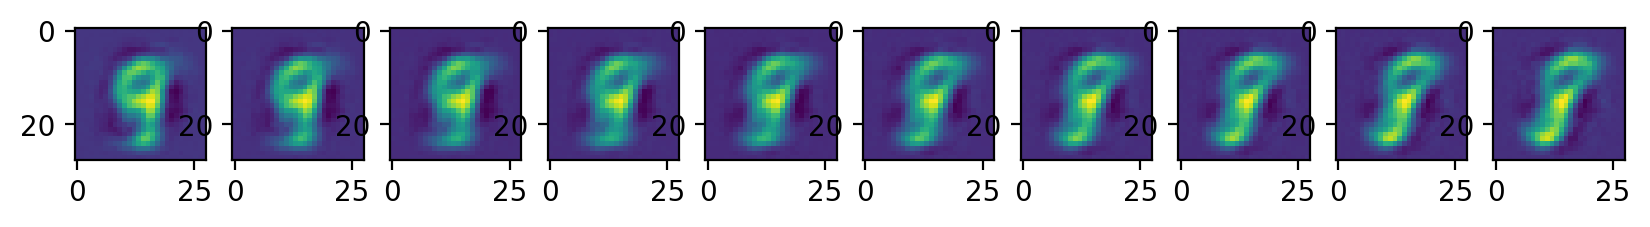

In [ ]:
start_img = net.encode(images[0].view(-1))
end_img = net.encode(images[1].view(-1))

f, axarr = plt.subplots(1,10, )
axarr[0].imshow(img.squeeze())
for i in range(10):
    path = torch.lerp(start_img, end_img, i * .1)
    axarr[i].imshow(net.decode(path).detach().squeeze().reshape(28, 28))
f.set_figheight(4)
f.set_figwidth(10)
plt.show()